In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from copy import copy
warnings.simplefilter("ignore")
plt.rcParams['font.sans-serif'] = ['SimHei']   
plt.rcParams['axes.unicode_minus'] = False 

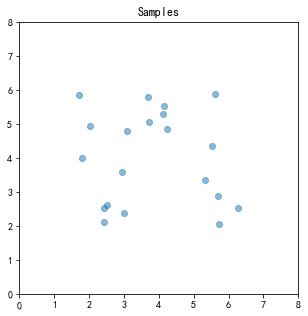

In [2]:
np.random.seed(5213)
x = np.random.rand(20, 2) * 5  + 1.5

plt.figure(figsize=(5, 5))
plt.title("Samples")
plt.scatter(x[:, 0], x[:, 1], alpha=0.5)
plt.xlim(0, 8)
plt.ylim(0, 8)
plt.show()

In [3]:
# 使用贪心策略，求解一个回路的值
points = [0, 5, 8, 10, 11, 13, 14, 18, 19, 0]
def greed_cicle(x, points):
    start, end = points[0], points[-1]
    cands = [points[i] for i in range(1, len(points)-1)]
    visit = [points[0]]
    dis_ls = list()
    while len(cands)>0:
        now = visit[-1]
        dis_min = np.inf
        nxt_min = None
        for nxt in cands:
            x1, x2 = x[now], x[nxt]
            dis = np.sqrt(np.sum(np.power(x1-x2, 2)))
            if dis < dis_min:
                dis_min = dis
                nxt_min = nxt
        visit.append(nxt_min)
        cands.remove(nxt_min)
        dis_ls.append(dis_min)
        pass
    
    now, nxt = points[-2], points[-1]
    x1, x2 = x[now], x[nxt]
    dis = np.sqrt(np.sum(np.power(x1-x2, 2)))
    visit.append(0)
    dis_ls.append(dis)
    dis_res = sum(dis_ls)
    
    return visit, dis_res
greed_cicle(x, points)

([0, 10, 8, 11, 18, 5, 19, 13, 14, 0], 13.558441004456634)

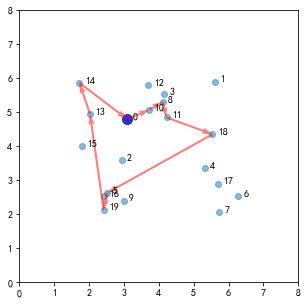

best_paths = 0 -> 10 -> 8 -> 11 -> 18 -> 5 -> 19 -> 13 -> 14 -> 0
best_distance = 13.558441004456634


In [4]:
best_paths, best_distance = greed_cicle(x, points)

plt.figure(figsize=(5, 5))
plt.xlim(0, 8)
plt.ylim(0, 8)
plt.scatter(x[:, 0], x[:, 1], alpha=0.5)
plt.scatter(x[0][0], x[0][1], c="blue", edgecolors="black", alpha=0.75, s=100)

for i in range(len(best_paths)-1):
    loc1, loc2 = best_paths[i], best_paths[i+1]
    x1, y1 = x[loc1]
    x2, y2 = x[loc2]
    dx = x2 - x1
    dy = y2 - y1
    plt.quiver(x1, y1, dx, dy, angles='xy', scale=1, scale_units='xy', color="red", alpha=0.5)

for i in range(len(x)):
    x1, y1 = x[i]
    plt.annotate(i, xy=(x1, y1), xytext=(x1+0.15, y1))
plt.show()

print(f"best_paths = {' -> '.join([str(i) for i in best_paths])}")
print(f"best_distance = {best_distance}")

In [5]:
'''
遗传算法求解MTSP问题
1、假如有n个点，需要m个回路，则每个生物体染色体形状为（m,n）
2、m条染色体的n个位置中，同位置只有一个为1，其余为0（每列只能有1个1）
3、m条染色体依次编码，只能在前一条染色体为0的位置，才能编辑为1（第2个圈只能选第1个圈剩下的节点）
4、m条染色体的n个基因位，1出现的次数必须是1（0次表示有个节点没有被访问到），且只能是1次（2次以上表示有个节点被重复访问）
5、m条染色体，除了起点，起码有1个位置是1（这个暂且搁置，如果为空说明不需要这条回路）
6、每一条染色体，都化简成为tsp问题来求解最短路径（突然觉得好麻烦啊）
'''


class MTSP_GA(object):
    def __init__(self, x, m, s, nums, min_pnt):
        self.x = x  # 节点列表
        self.n = len(x)  # 节点个数
        self.m = m  # 回路个数（旅行商人的个数）
        self.s = s
        self.min_pnt = min_pnt
        self.nums = nums # 生物体个数
        self.colony = list() # 生物群，数量为200
        self.colony_save = list() # 经过淘汰的生物群，数量为100
        self.couples = list() # 生物群配对，50对伴侣
        self.colony_circles = list()  # 生物群的回路表达
        self.colony_behave = list()
        return
    
    def born(self):
        flag = True
        gene = None
        while flag:
            gene = [[0 for _ in range(self.n+1)] for __ in range(self.m)]
            for i in range(m):
                gene[i][self.s] = 1
                gene[i][-1] = 1
            # print(gene)
            seen = [0 for i in range(self.n+1)] # 用于记录m条染色体重，各个位置上是否已经有1
            seen[0] = 1
            seen[-1] = 1
            for i in range(self.m-1): # 最后1条染色体另外处理，会将所有剩余节点标记为1
                for j in range(1, self.n):
                    if np.random.rand()>=(1 - 1/self.m) and seen[j]!=1:
                        gene[i][j] = 1
                        seen[j] = 1
            for j in range(1, self.n): # 最后1条染色体，将剩余节点标记在染色体上
                if seen[j]!=1:
                    gene[self.m-1][j] = 1
                    seen[j] = 1  
            flag = False 
            for g in gene:
                if sum(g)<=5: # 如果存在1条染色体只包含起点和终点，重新生成其余基因型
                    flag = True
                    break
        return gene
    
    def born_colony(self):
        self.colony = list()
        for i in range(self.nums):
            gene = self.born()
            self.colony.append(gene)
        return 
    
    def appear(self): # 将基因线性表达成为回路
        self.colony_circles = list()
        for chromo in self.colony:
            circle_m = list() # 一个生物体上的m条回路
            for gene in chromo:
                circle = list()  # 一条染色体上的回路
                for bit in range(len(gene)-1):
                    if gene[bit] == 1:
                        circle.append(bit)
                if gene[-1] == 1:
                    circle.append(self.s)  # 最终回路要加上起点
                circle_m.append(copy(circle))
            self.colony_circles.append(copy(circle_m))                 
        return
    
    def behave(self):
        
        # 按照总路径进行计算，结果得分保存到 self.colony_behave
        self.colony_behave = list()
        for i, circles in enumerate(self.colony_circles):
            bst_pat_m = list()
            bst_dis_m = list()
            for points in circles:
                bst_pat, bst_dis = greed_cicle(x, points)
                bst_pat_m.append(copy(bst_pat))
                bst_dis_m.append(copy(bst_dis))
            bst_dis_s = sum(bst_dis_m)
            self.colony_behave.append((copy(self.colony[i]), copy(bst_pat_m), copy(bst_dis_m), copy(bst_dis_s)))
        
        # 只保留50%的最优值，结果保存到 self.colony_save
        self.colony_save = sorted(self.colony_behave, key=lambda x:x[3])[:nums//2]  
        return
    
    def compire(self): # 对样本进行配对
        self.couples = list()
        nums = len(self.colony_save)
        cands = list(range(nums))
        np.random.shuffle(cands)
        pair1 = list() # 雄性
        pair2 = list() # 雌性
        for i in range(0, nums, 2):
            pair1.append(cands[i])
            pair2.append(cands[i+1])
        self.couples = list(zip(pair1, pair2))
        # print(self.couples)
        return
    
    def reproduction(self):
        ger_ls = list()
        for couple in self.couples:
            flag = True
            cnts = 0
            while cnts<4:
                id1, id2 = couple
                an1, an2 = self.colony_save[id1], self.colony_save[id2]
                ge1, ge2 = an1[0], an2[0]  # 染色体组合
                nums = len(ge1)
                bits = len(ge1[0])
                sen = [1] + [0]*(bits-2) + [1]
                ger = list()
                for i in range(nums):
                    g1, g2 = ge1[i], ge2[i] # 单条染色体的基因合租
                    g = [1] + [0]*(bits-2) + [1] # 交配产生的新染色体
                    for j in range(1, bits-1):
                        if np.random.rand()>=0.5:
                            g[j] = g1[j]
                        else:
                            g[j] = g2[j]
                        if sen[j] == 1:
                            g[j] = 0 # 如果该基因位被占用，只能被抑制成为0
                        if g[j] == 1: 
                            sen[j] = 1 # 如果该基因位被占用，标记为1
                    ger.append(copy(g))

                # 从sen中找到还没被使用的基因位，随机放到m个染色体中的某一个
                for k in range(len(sen)):
                    if sen[k] == 0:
                        ms = np.random.choice(range(len(ger))) # 被选中的染色体
                        ger[ms][k] = 1

                # 变异，按照5%的概率变异每条染色体
                for i in range(nums):
                    for j in range(1, bits-1):
                        if np.random.randn()<0.05:
                            tmp = ger[i][j]
                            ks = [_ for _ in range(nums) if _ != i]
                            if tmp == 0:
                                ger[i][j] = 1
                                for k in ks:
                                    ger[k][j] = 0
                            else:
                                ger[i][j] = 0
                                k = np.random.choice(ks)
                                ger[k][j] = 1
                # 如果生出来的基因型不满足5个节点，重新生
                pnts = min([sum(v) for v in ger])
                if pnts < self.min_pnt + 2:   # 等于7，去头去尾表示要经过其他5个城市
                    continue
                ger_ls.append(copy(ger))
                cnts += 1
        return ger_ls
    
    def run(self, loops):
        self.born_colony()
        best_result = None
        best_dis = np.inf
        for i in range(loops):
            self.appear()
            self.behave()
            self.compire()
            ger_ls = self.reproduction()
            self.colony = ger_ls
            if best_dis > self.colony_save[0][3]:
                best_dis = self.colony_save[0][3]
                best_result = copy(self.colony_save[0])
            if i % 100 == 0:
                print(f"loop = {i}, finished!, best_dis = {best_result[3]}")
        return best_result
    pass

In [6]:
%%time

m = 3 # 回路个数
s = 0 # 起始地点
nums = 200 # 生物群中的个体数
min_pnt = 5 # 每条回路最少要包含的节点数
mstp = MTSP_GA(x, m, s, nums, min_pnt)

loops = 2000+1 # 迭代次数
best_res = mstp.run(loops)

loop = 0, finished!, best_dis = 31.20734555207725
loop = 100, finished!, best_dis = 28.327104669778215
loop = 200, finished!, best_dis = 28.18710966028309
loop = 300, finished!, best_dis = 27.333347409866064
loop = 400, finished!, best_dis = 27.333347409866064
loop = 500, finished!, best_dis = 27.333347409866064
loop = 600, finished!, best_dis = 26.603616105437588
loop = 700, finished!, best_dis = 26.603616105437588
loop = 800, finished!, best_dis = 25.97639895089724
loop = 900, finished!, best_dis = 25.97639895089724
loop = 1000, finished!, best_dis = 25.97639895089724
loop = 1100, finished!, best_dis = 25.97639895089724
loop = 1200, finished!, best_dis = 25.97639895089724
loop = 1300, finished!, best_dis = 25.97639895089724
loop = 1400, finished!, best_dis = 25.837817123433375
loop = 1500, finished!, best_dis = 25.837817123433375
loop = 1600, finished!, best_dis = 25.837817123433375
loop = 1700, finished!, best_dis = 25.837817123433375
loop = 1800, finished!, best_dis = 25.8378171234

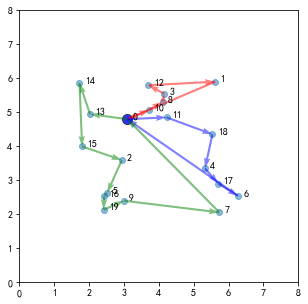

bst_dis_ls = [4.983346638984058, 7.305431061233611, 12.858666205298912]
best_distance = 25.14744390551658


In [7]:
plt.figure(figsize=(5, 5))
plt.xlim(0, 8)
plt.ylim(0, 8)
plt.scatter(x[:, 0], x[:, 1], alpha=0.5)
plt.scatter(x[0][0], x[0][1], c="blue", edgecolors="black", alpha=0.75, s=100)

bst_paths_ls = best_res[1]
bst_dis_ls = best_res[2]
best_distance = best_res[3]
colors = ["red", "blue", "green"]
for c, best_paths in enumerate(bst_paths_ls):
    for i in range(len(best_paths)-1):
        loc1, loc2 = best_paths[i], best_paths[i+1]
        x1, y1 = x[loc1]
        x2, y2 = x[loc2]
        dx = x2 - x1
        dy = y2 - y1
        plt.quiver(x1, y1, dx, dy, angles='xy', scale=1, scale_units='xy', color=colors[c], alpha=0.5)

for i in range(len(x)):
    x1, y1 = x[i]
    plt.annotate(i, xy=(x1, y1), xytext=(x1+0.15, y1))

plt.show()
# print(f"best_paths = {' -> '.join([str(i) for i in best_paths])}")
print(f"bst_dis_ls = {bst_dis_ls}")
print(f"best_distance = {best_distance}")

### 可以看出，贪心策略带来的小回路是有缺陷的；
### 可以考虑用（贪心+蚁群）的算法来对单条回路进行优化
### 先用贪心算法布下信息素，然后让蚂蚁优化这个路径；